### **Trabajo Final para la Cátedra de Fundamentos de Analítica I**
#### El objetivo del presente proyecto es la supervivencia en el Titanic, así como establecer una caracterización de los sobrevivientes y de aquellos que tuvieron el mismo final que Jack.

##### Realizado por:
  - Claudia Lorena Aragón 
  - Álvaro José Cabrera
  - Álvaro Rodríguez Lasso
  - Alfredo Aponte Segura

In [1]:
# Import de librarias necesarias para el proyecto
import pandas as pd
import sklearn
import seaborn as sns
import numpy as np
import missingno as msno
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from scipy.stats import randint
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

#  Visualization
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


# Funciones para análisis de atípicos
from scipy.stats import skew, kurtosis  ## funciones estadísticas
def tabla_descriptivas(columnas):
    tabla_descriptivas=pd.DataFrame(columnas.describe())
    tabla_descriptivas.loc['coef. variation 0.30 | 0.30-0.70 | 0.70']=columnas.std()/columnas.mean()
    tabla_descriptivas.loc['skew < 0 sesgo izquierda | > 0 sesgo derecha ']=skew(columnas) #Sesgo o asimetría
    tabla_descriptivas.loc['kurtosis <0 achatada platicurtica | > 0 empinada leptocurtica']=kurtosis(columnas)
    q1=columnas.quantile(0.25)
    q3=columnas.quantile(0.75)
    IQR=q3-q1
    outliers = columnas[ ((columnas<(q1-1.5*IQR)) | (columnas>(q3+1.5*IQR))) ]
    outlier_minimos = columnas[columnas<(q1-1.5*IQR)]
    outlier_maximos = columnas[columnas>(q3+1.5*IQR)]
    tabla_descriptivas.loc['Umbral atípicos minimo']=  columnas.quantile(0.25) - (columnas.quantile(0.75) - columnas.quantile(0.25))*1.5
    tabla_descriptivas.loc['Umbral atípicos maximo']=  columnas.quantile(0.75) + (columnas.quantile(0.75) - columnas.quantile(0.25))*1.5
    #tabla_descriptivas.loc['cantidad atipicos minimos']=   len(outlier_minimos)
    #tabla_descriptivas.loc['cantidad atipicos maximos']= len(outlier_maximos)
    #tabla_descriptivas.loc['cantidad_total_atípicos']= len(outliers)
    return tabla_descriptivas

### 1. Limpieza y EDA

#### Cargue de datos

In [2]:
df_completo = pd.read_csv("train.csv") #Dataset completo
#Split de datasets para generar un set de test por python, dado que no hay etiquetas en el set de test de Kaggle.
df_train, df_test = train_test_split(df_completo, test_size=0.2, random_state=42) 
df_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
331,332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.500,C124,S
733,734,0,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.000,NaN,S
382,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.925,NaN,S


#### Validación general de formatos del dataset, datos faltantes y duplicados

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 331 to 102
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          572 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        159 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [4]:
df_train.isnull().mean()*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.662921
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.668539
Embarked        0.280899
dtype: float64

In [5]:
df_train.duplicated().sum()

0

Encontramos un data set de entrenamiento con 891 registros. Las variables se encuentran correctamente formateadas.  Sin embargo, la variable "Cabin", presenta un 77% de datos faltantes por lo que se descartará del análisis posteriormente.  Por otro lado las variables "Age" y "Embarked" presentan aproxidamente un 20% de datos faltantes, por lo que se deberán imputar. Finalmente, no se presentan valores duplicados.

#### Eliminación de variables innecesarias del dataset

In [6]:
df_train = df_train.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
df_test = df_test.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

Eliminamos variables cualitativas que no nos aportan en nuestro objetivo o presentan mayor proporción de valores nulos: "PassengerId", "Name", "Ticker", "Cabin".  Adicionalmente, la cabina se explica con la clase de la persona (multicolinealidad).

#### Análisis descriptivo

#### Distribución de las variables cuantitativas

In [7]:
tabla_descriptivas(df_train[['Age', 'SibSp','Parch','Fare']])

,Age,SibSp,Parch,Fare
count,572.000000,712.000000,712.000000,712.000000
mean,29.498846,0.553371,0.379213,32.586276
std,14.500059,1.176404,0.791669,51.969529
min,0.420000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,7.925000
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,30.500000
max,80.000000,8.000000,6.000000,512.329200
coef. variation 0.30 | 0.30-0.70 | 0.70,0.491547,2.125888,2.087661,1.594829
skew < 0 sesgo izquierda | > 0 sesgo derecha,NaN,3.611755,2.689777,4.864789


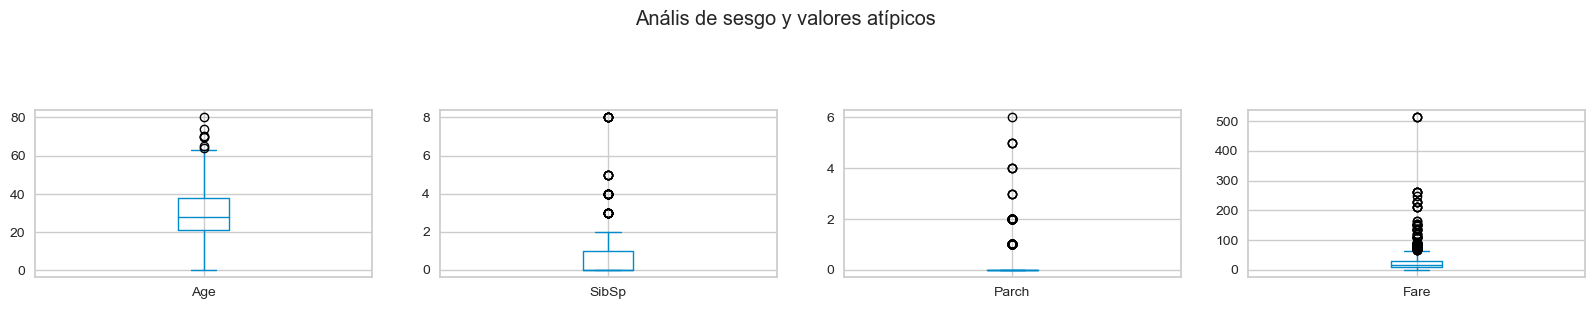

In [8]:
df_atipicos = df_train.drop(columns=['Pclass', 'Sex', 'Embarked', 'Survived'])
boxplot = df_atipicos.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(20,10), title='Anális de sesgo y valores atípicos', color="#008ACC" )
plt.show()

Age: 

-El 50% de la distribución de los datos se encuentra entre 20 y 38 años, con centro 28, es decir adultos jóvenes.

-Presenta unos cuantos atípicos de cara a edades máximas, superiores a 64 años. Son datos válidos.

Sibsp (nro. hermanos / cónyuges aboard the Titanic)

-El 50% de la distribución de los datos se encuentra entre 0 y 1, con centro 0.

-Presenta unos cuantos atípicos máximos superiores a 2.

Parch (Nro. de padres / hijos a bordo del Titanic)

-El 50% de la distribución de los datos se encuentra entre 0 y 0, con centro 0.

-Presenta unos cuantos atípicos máximo superiores a 0.

Fare (Tarifa)

-El 50% de la distribución de los datos se encuentra entre 7.91 y 31, con centro 14.4.

-Presenta una gran cantidad de datos atípicos, con valores superioes a 65.

#### Relación de variables cuantitativas Vs. variable objetivo y separación de tipo de variables

In [9]:
#Coerción y marcación de variables para graficar
df_train['Survived'] = df_train['Survived'].astype('category') # Asegúrarse de que la columna 'Survived' sea categórica para facilitar la visualización
df_test['Survived'] = df_test['Survived'].astype('category') # Asegúrarse de que la columna 'Survived' sea categórica para facilitar la visualización
df_train['Pclass'] = df_train['Pclass'].astype('category') # Asegúrarse de que la columna 'Survived' sea categórica para facilitar la visualización
df_test['Pclass'] = df_test['Pclass'].astype('category') # Asegúrarse de que la columna 'Survived' sea categórica para facilitar la visualización



# Separando las variables cuantitativas de las cualitativas
# Las variables cuantitativas son 'Age' y 'Fare'
quantitative_cols = ['Age', 'SibSp','Parch','Fare']
# Las variables cualitativas son 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked'
qualitative_cols = ['Pclass', 'Sex', 'Embarked']

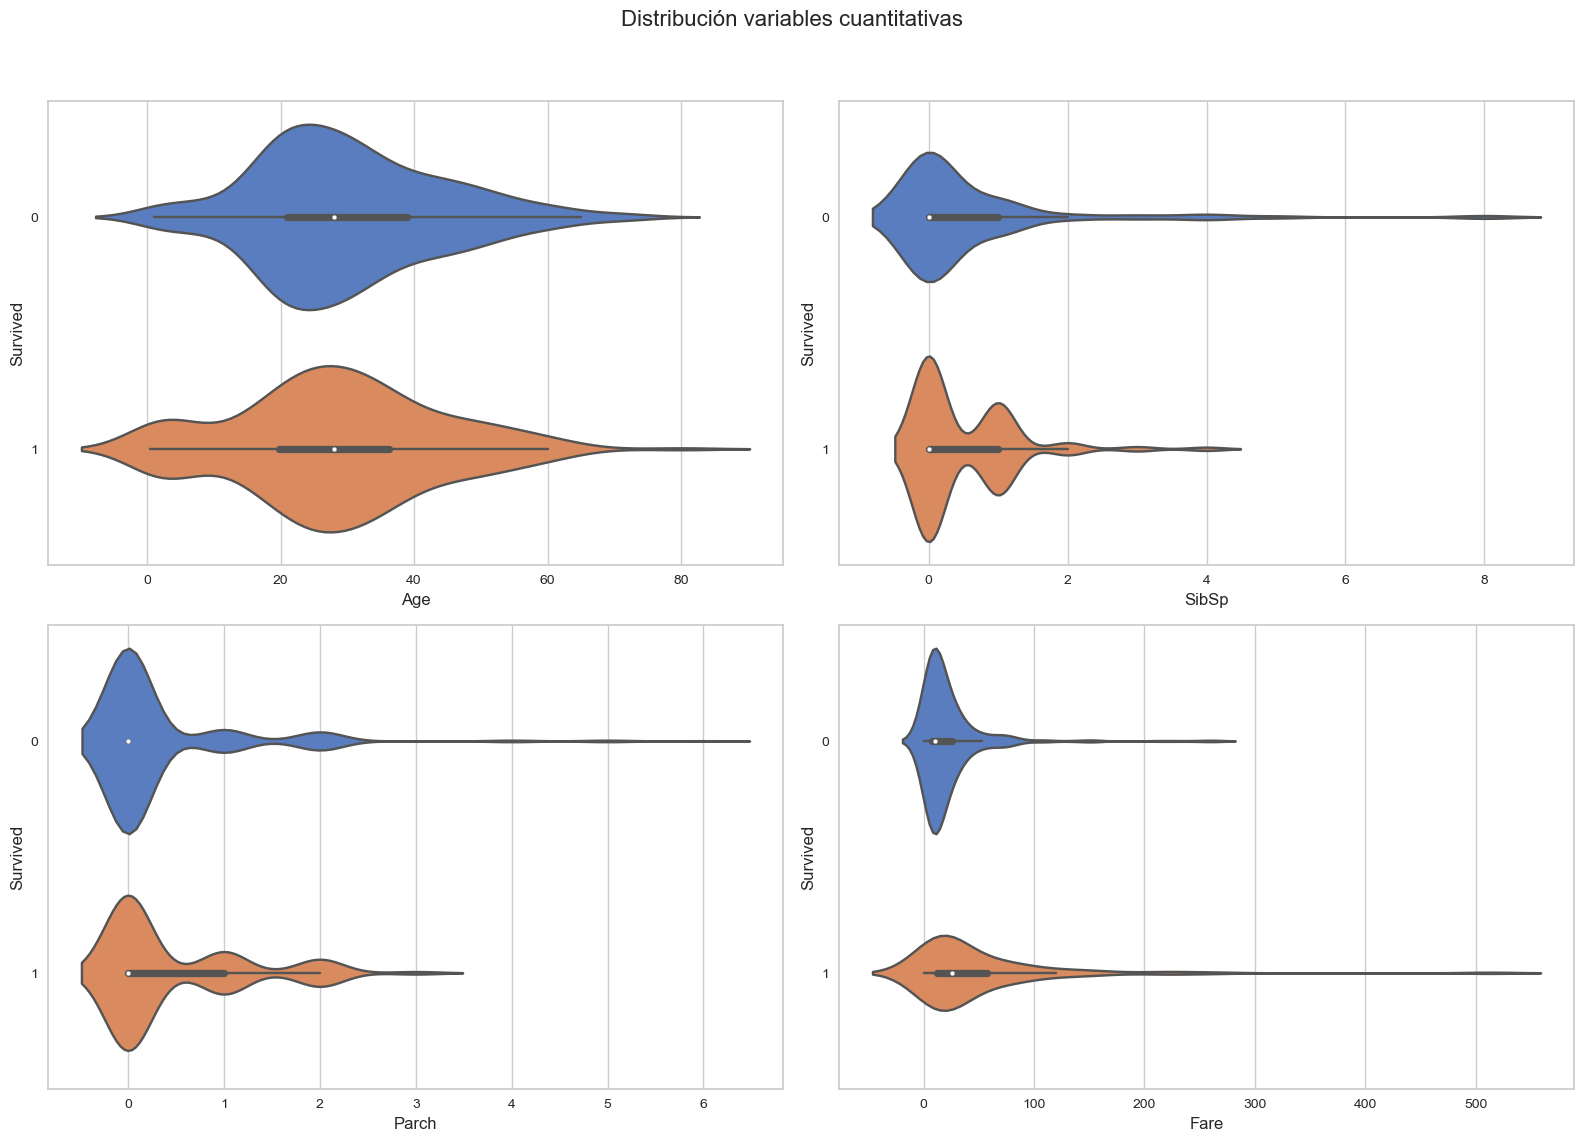

In [10]:
# Crear un tablero para gráficos de violín de variables cuantitativas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
fig.suptitle('Distribución variables cuantitativas', fontsize=16)

for i, col in enumerate(quantitative_cols):
    ax = axes[i // 2, i % 2] # distribución del gráfico en la cuadrículas
    sns.violinplot(y='Survived', x=col, data=df_train, ax=ax, palette="muted")

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # espacios de los subplots
plt.show()

Edad:

Los sobrevivientes presentan una mayor frecuencia en edades bajas y menores frecuencias en edades muy avanzadas.

Sibsp (nro. hermanos / cónyuges aboard the Titanic):

Los sobrevivientes presentan dos grupos claramente identificables: sin sibsp o con 1 sibsp, estos últimos presentan mayor frecuencia que en los fallecidos.  En los fallecidos estos dos grupos no se ven tan claramente, además que presentan datos atípicos máximos: lo anterior implica que en el test de entrenamiento no se salvaron familias numerosas.

Parch (Nro. de padres / hijos a bordo del Titanic)

En los sobrevivientes existe más frecuencia en los valores 1 y 2

Fare (Tarifa)

Los sobrevivientes tienen su centro de distribución un poco más arriba que los fallecidos.   Adicionalmente, en los sobrevivientes se observa datos atípicos con valores muy altos.

#### Análisis visual de correlación 

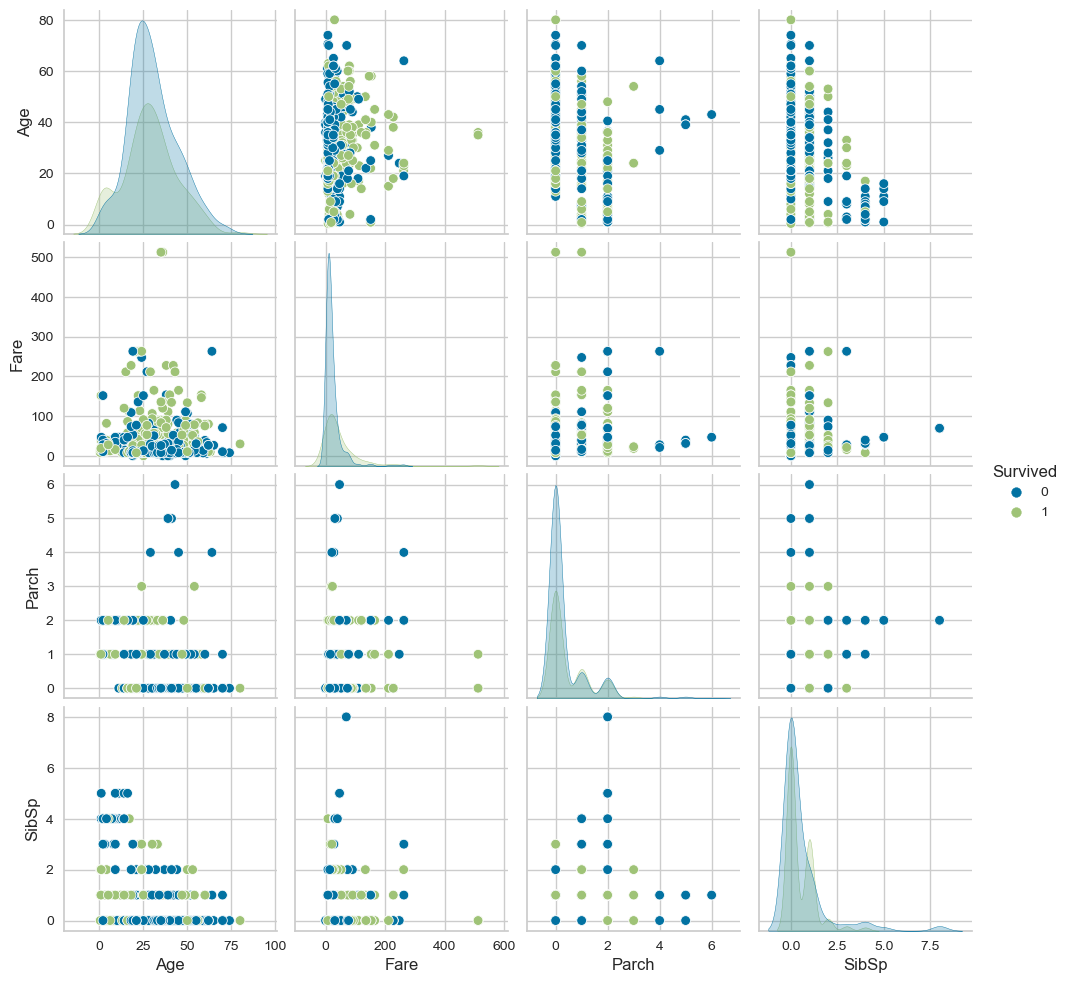

In [11]:
palette = {0: "red", 1: "green"}
sns.pairplot(data=df_train[['Age', 'Fare', 'Parch', 'SibSp','Survived']], hue="Survived")

**Análisis de dispersión vs. variable objetivo**:

Age: Edad de los pasajeros. La edad más frecuente entre los pasajeros del titánic fue 25 años en los fallecidos

Fare: La tarifa del boleto pagado por los pasajeros más frecuente fue un valor muy mínimo cercano a 0 en fallecidos.

Parch: El número de padres e hijos a bordo más frecuente fue de cero (0) en fallecidos, es decir que no iban con padre o hijos en el titánica.

SibSp: Se observa que la mayoría de los pasajeros fueron los fallecidos que no tenían hermanos ni conyugue es decir más frecuente 0.

**Gráficos de dispersión**

Age vs. Fare: No se observa una correlación lineal entre la edad y el costo del boleto; por lo que el pago de tarifa en sobrevivientes y no sobrevivientes no tiene una tendencia lineal, es decir que no incide la edad en el pago de la tarifa

Age vs. Parch: No hay una tendencia clara en la relación entre edad y número de padres/hijos a bordo. Observándose que la mayor concentración de puntos con respecto a Parch de 0 y algunos valores atípicos en esta variable con un numero de 6 padres/hijos a bordo.

Age vs. SibSp: No hay una tendencia clara entre edad y número de hermanos/cónyuges a bordo.

Fare vs. Parch: La mayoría de los pasajeros con Parch = 0 pagaron tarifas bajas. Algunos con Parch > 0 pagaron tarifas más altas, pero no hay una tendencia clara.

Fare vs. SibSp: Los pasajeros con más hermanos/cónyuges tienden a haber pagado tarifas variadas, pero sin una tendencia clara.

Parch vs. SibSp: Algunos tienen combinaciones de valores más altos, pero son menos comunes.




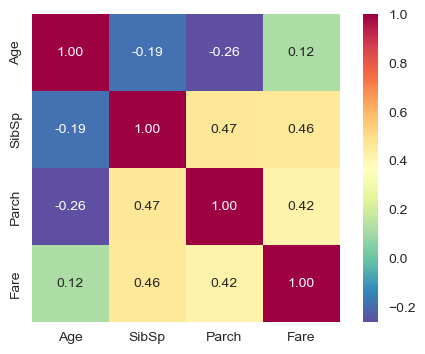

In [12]:
# Calcular la matriz de correlación de Spearman
corrmat = df_train[quantitative_cols].corr(method='spearman')
plt.figure(figsize=(6, 4))
hm = sns.heatmap(corrmat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 10}, #tamaño de la fuente del cuadro
                 yticklabels=df_train[quantitative_cols].columns,
                 xticklabels=df_train[quantitative_cols].columns,
                 cmap="Spectral_r")
plt.show()

Utilizamos una medida de correlación no paramétrica (correlación de spearman) dada la alta cantidad de atípicos del set de datos.  Se identifican posibles multicolinealidades bajas entre:

-Parch y Fare.
-SibSp y Fare.
-SibSp y Parch.

La edad no está correlacionada notoriamente con otra variable cuantitativa.

#### Análisis de variables cualitativas

#### Label encoding (para graficar)

In [13]:
mapping_pclass   = {'1': 'Upper', '2': 'Middle', '3': 'Lower'}
mapping_survived = {'1': 'Survived', '0': 'No'}

# Reemplazar los valores en la columna 'Pclass'
df_train['Pclass'] = df_train['Pclass'].replace(mapping_pclass)
df_test['Pclass'] = df_test['Pclass'].replace(mapping_pclass)

df_train['Survived'] = df_train['Survived'].replace(mapping_survived)
df_test['Survived'] = df_test['Survived'].replace(mapping_survived)

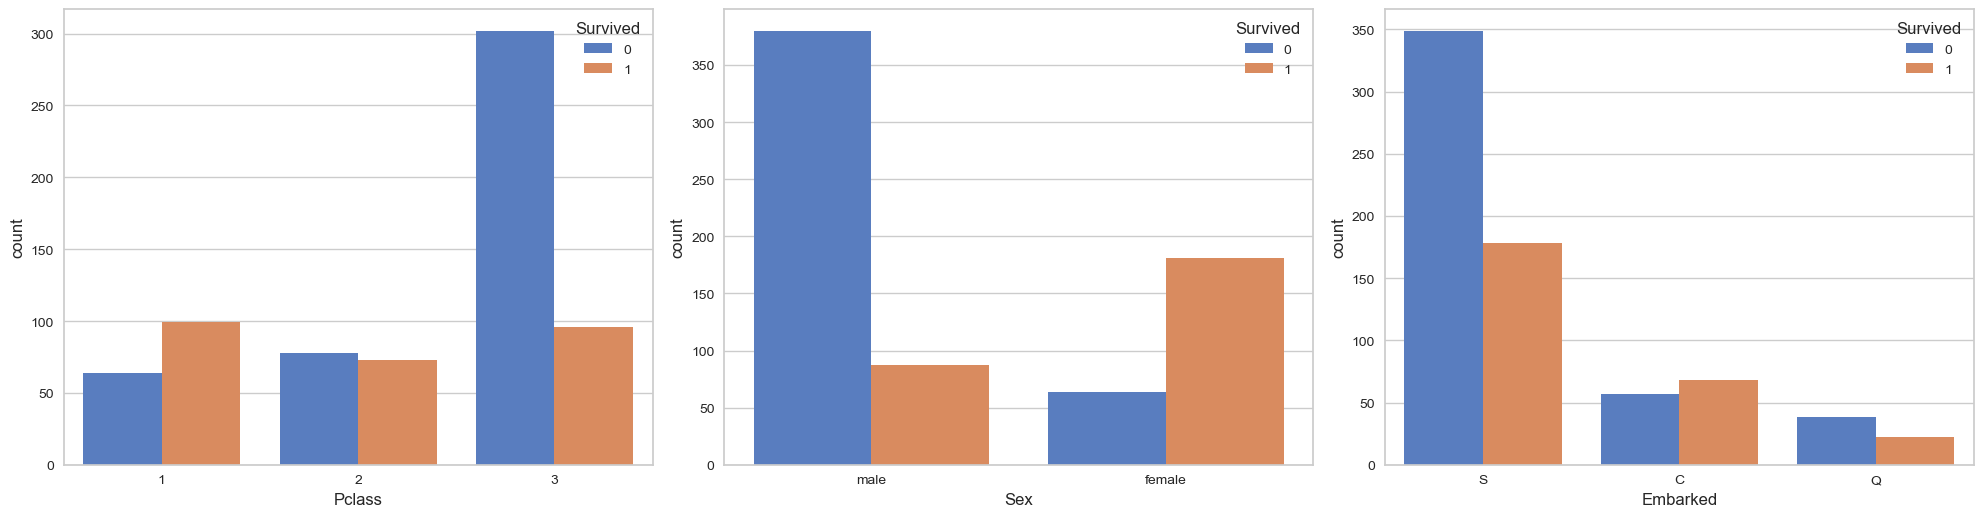

In [57]:

# Visualización de variables cualitativas vs Survived
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
fig.suptitle('', fontsize=16)

for i, col in enumerate(qualitative_cols):
    ax = axes[i]
    sns.countplot(x=col, hue='Survived', data=df_train, ax=ax, palette="muted")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

PClass1:  la clase mayoritaría son los sobrevivientes.

PClass2:  la clase de fallecidos, está un poco por encima de sobrevivientes. 

PClass3:  la clase de fallecidos es la mayoritaria.

Male: la clase mayoritaria es fallecidos.

Famale: la clase mayoritaria es sobreviviente.

Southampton (S , clase media y alta 50%, clase baja  50%): la clase mayoritaria es fallecidos.

Cherbourg (C, mayoritariamente clase alta 1): la clase mayoritaria es sobreviviente.

Queenstown (Q, mayoritariamente clase baja 3):  la clase mayoritaria  es fallecidos.

#### Visualización de datos faltantes previo a imputación

<Axes: >

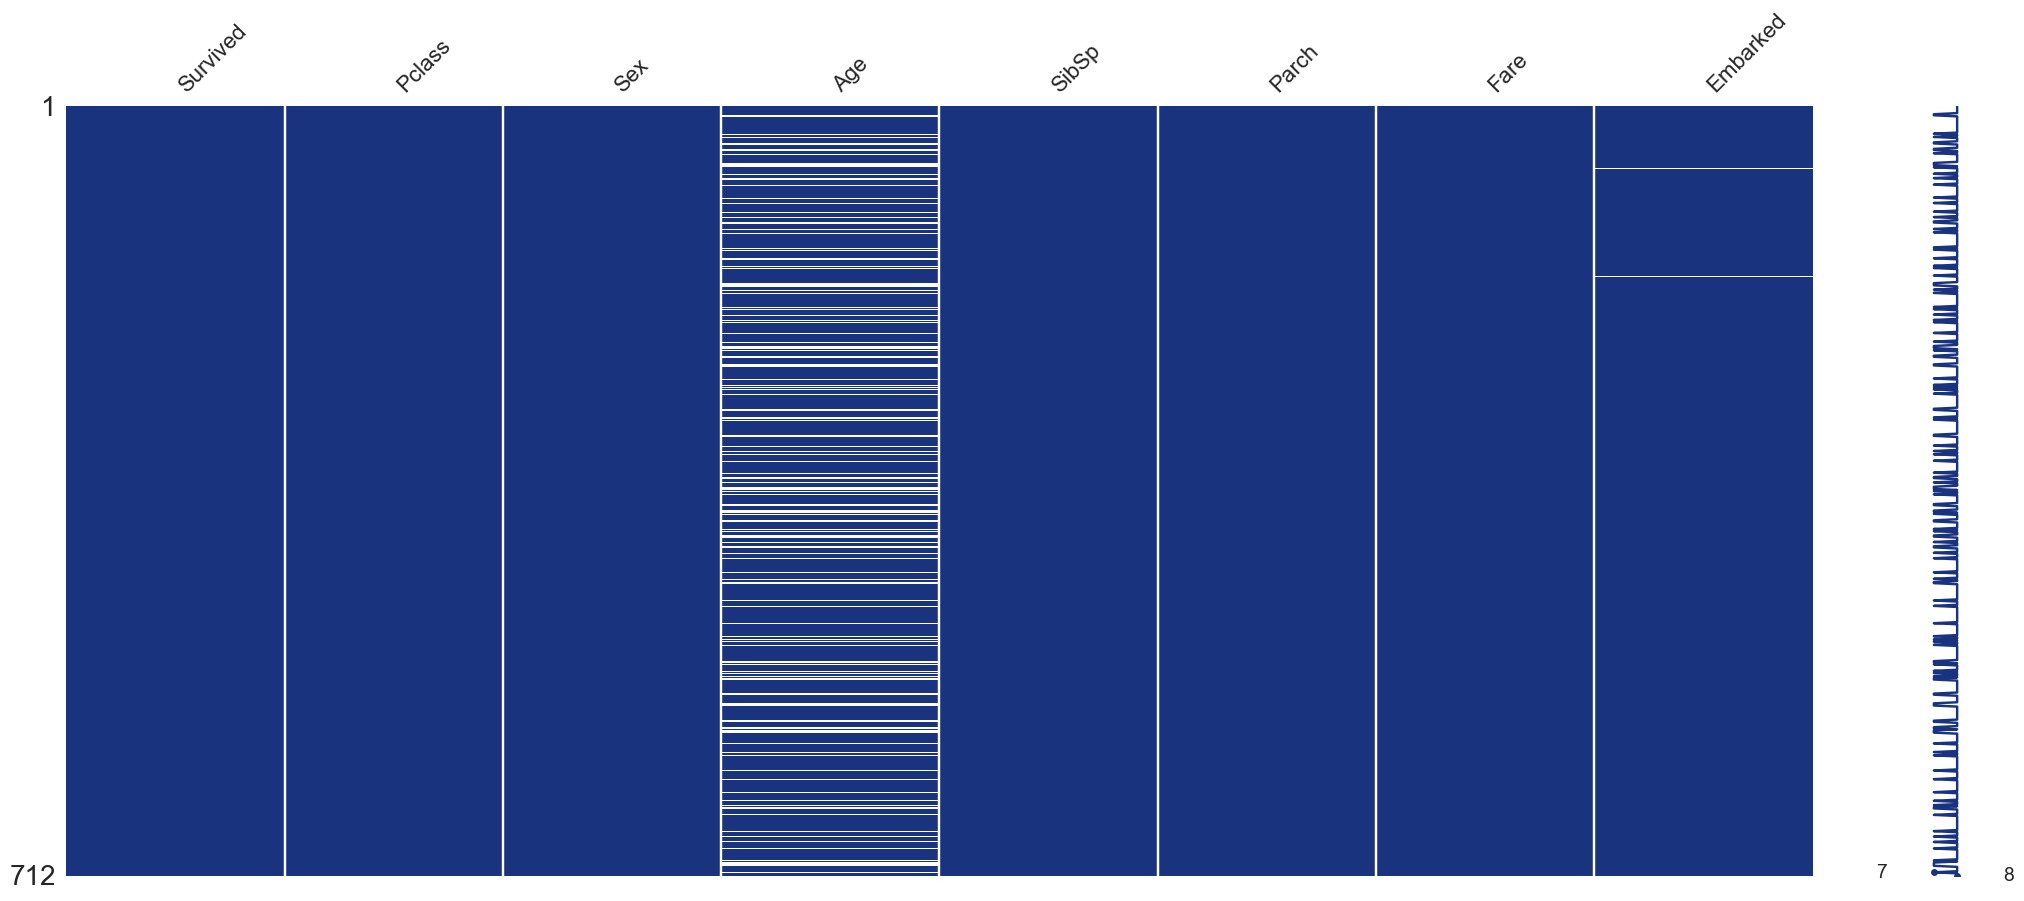

In [15]:
msno.matrix(df_train, color = (0.1, 0.2, 0.5)) #print(msno.matrix(df_train))

#### Imputación

<Axes: >

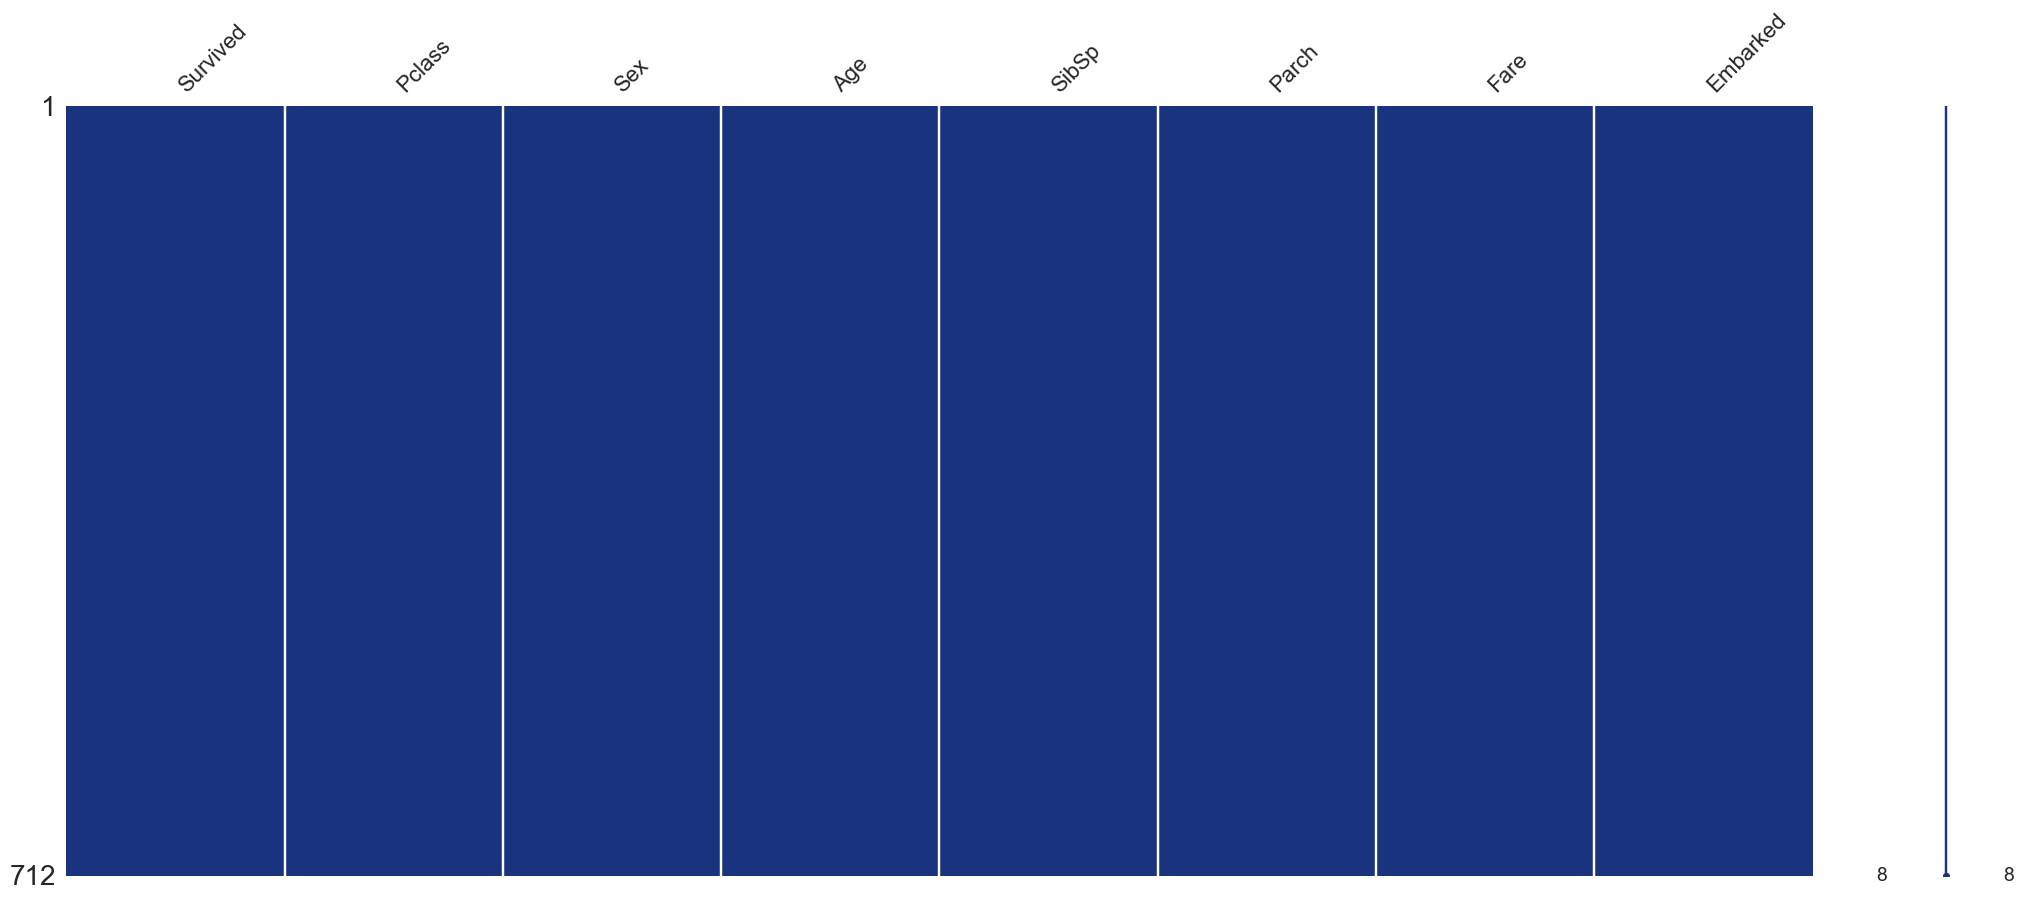

In [16]:
# Imputación #
imputer = SimpleImputer(strategy='most_frequent')
df_train['Embarked'] = imputer.fit_transform(df_train[['Embarked']])


# Crea el objeto KNNImputer con 5 vecinos
knn_imputer = KNNImputer(n_neighbors=5)

# Imputación de las variables cuantitativas
# Se imputan los valores faltantes de las columnas 'Age' y 'Fare' utilizando KNNImputer
df_train[quantitative_cols] = knn_imputer.fit_transform(df_train[quantitative_cols])

#-----------------------------------------------------------------------------------------

#### Segundo datasets
# Imputación #
df_test['Embarked'] = imputer.fit_transform(df_test[['Embarked']])

# Crea el objeto KNNImputer con 5 vecinos
knn_imputer = KNNImputer(n_neighbors=5)

# Imputación de las variables cuantitativas
# Se imputan los valores faltantes de las columnas 'Age' y 'Fare' utilizando KNNImputer
df_test[quantitative_cols] = knn_imputer.fit_transform(df_test[quantitative_cols])

# Visualiza la matriz de valores faltantes después de la imputación
msno.matrix(df_train, color = (0.1, 0.2, 0.5))

Se observa que los valores han sido correctamente imputados

#### Generación de matrices de entrenamiento|pruebas y label encoding

In [17]:
#Selección de matriz de entrenamiento y de prueba

X_train=df_train[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
X_test=df_test[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]

y_train=df_train.iloc[:,0]
y_test=df_test.iloc[:,0]
y_train = y_train.replace({'No': 0, 'Survived': 1})
y_test = y_test.replace({'No': 0, 'Survived': 1})

#### One Hot encoding

In [18]:
# One-hot encode the categorical columns
X_train_encoded = pd.get_dummies(X_train[qualitative_cols], columns=qualitative_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test[qualitative_cols], columns=qualitative_cols, drop_first=True)
# Combine the encoded categorical columns with the numerical columns
X_train_final = pd.concat([X_train_encoded, X_train.drop(columns=qualitative_cols)], axis=1)
X_test_final = pd.concat([X_test_encoded, X_test.drop(columns=qualitative_cols)], axis=1)
X_test_final

,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Age,SibSp,Parch,Fare
709,0,1,1,0,0,23.8,1.0,1.0,15.2458
439,1,0,1,0,1,31.0,0.0,0.0,10.5000
840,0,1,1,0,1,20.0,0.0,0.0,7.9250
720,1,0,0,0,1,6.0,0.0,1.0,33.0000
39,0,1,0,0,0,14.0,1.0,0.0,11.2417
...,...,...,...,...,...,...,...,...,...
433,0,1,1,0,1,17.0,0.0,0.0,7.1250
773,0,1,1,0,0,23.2,0.0,0.0,7.2250
25,0,1,0,0,1,38.0,1.0,5.0,31.3875
84,1,0,0,0,1,17.0,0.0,0.0,10.5000


### 2. Modelos predictivos 

#### 2.1 Regresion Logistica

In [19]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(X_train_final, y_train)

y_pred = logreg.predict(X_test_final)

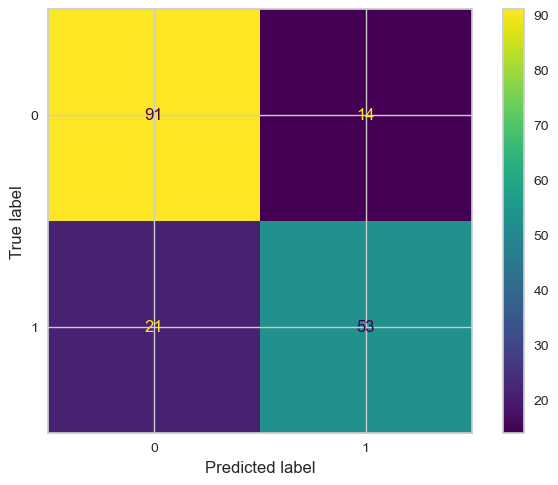

In [20]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cnf_matrix).plot()

In [21]:
target_names = ['No', 'Survived']
print(classification_report(y_test, y_pred, target_names=target_names))


              precision    recall  f1-score   support

          No       0.81      0.87      0.84       105
    Survived       0.79      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



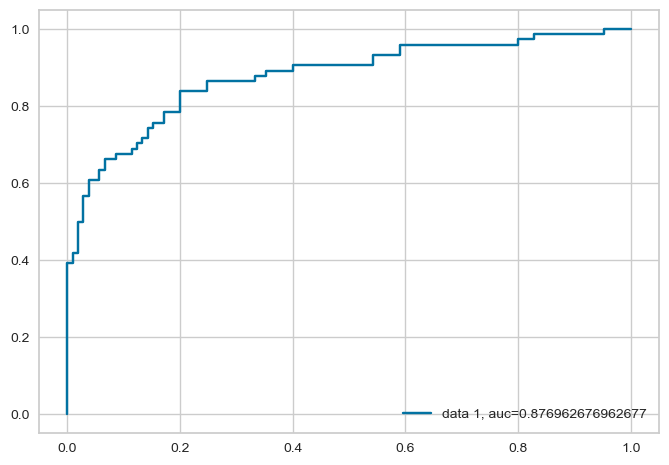

In [22]:
y_pred_proba = logreg.predict_proba(X_test_final)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### 2.2 Random Forest

In [23]:
rf = RandomForestClassifier()
rf.fit(X_train_final, y_train)
y_pred = rf.predict(X_test_final)
accuracy = accuracy_score(y_test, y_pred)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_matrix)
print(classification_report(y_test, y_pred, target_names=target_names))

[[89 16]
 [18 56]]
              precision    recall  f1-score   support

          No       0.83      0.85      0.84       105
    Survived       0.78      0.76      0.77        74

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



In [24]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000238923BD6C0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023891EDD5D0>})

In [25]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 7, 'n_estimators': 296}


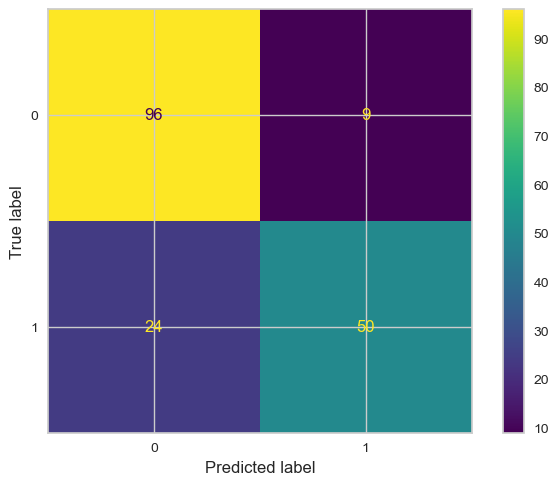

In [26]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test_final)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

<Axes: >

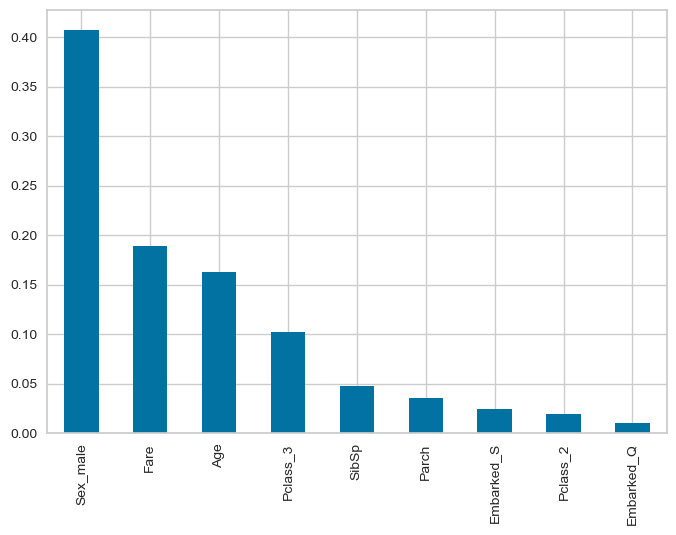

In [27]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_test_final.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()

#### 2.3 Decision Tree

In [28]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train_final,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_final)


In [29]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.8044692737430168


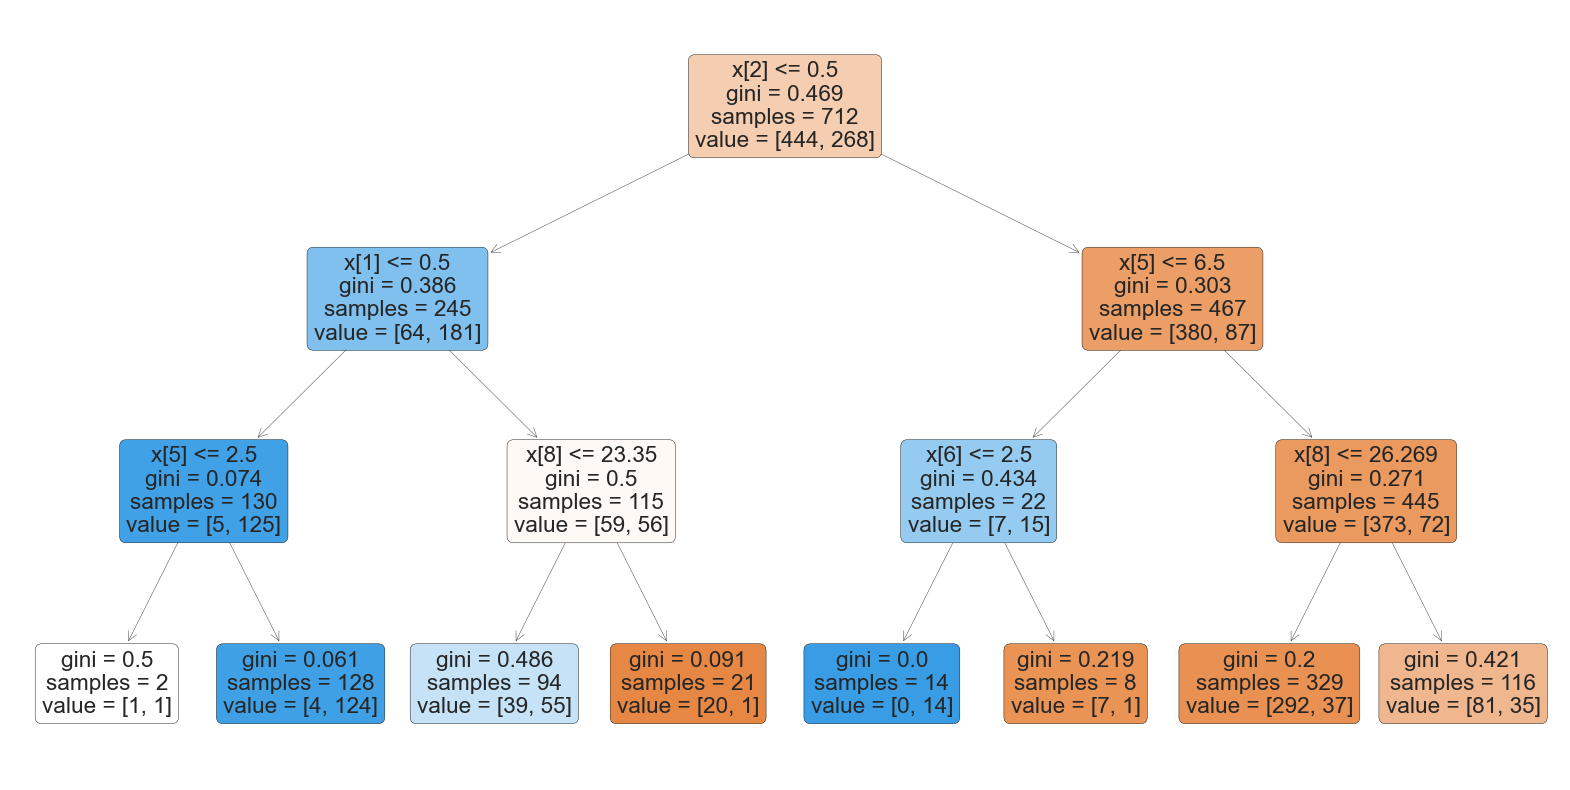

In [30]:

# Create Decision Tree classifer object with max_depth=3
clf = DecisionTreeClassifier(max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train_final, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_final)

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, rounded=True)
plt.show()

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Mejores parámetros encontrados:
{'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'random'}
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       105
           1       0.82      0.64      0.72        74

    accuracy                           0.79       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.80      0.79      0.79       179

Exactitud:
0.7932960893854749


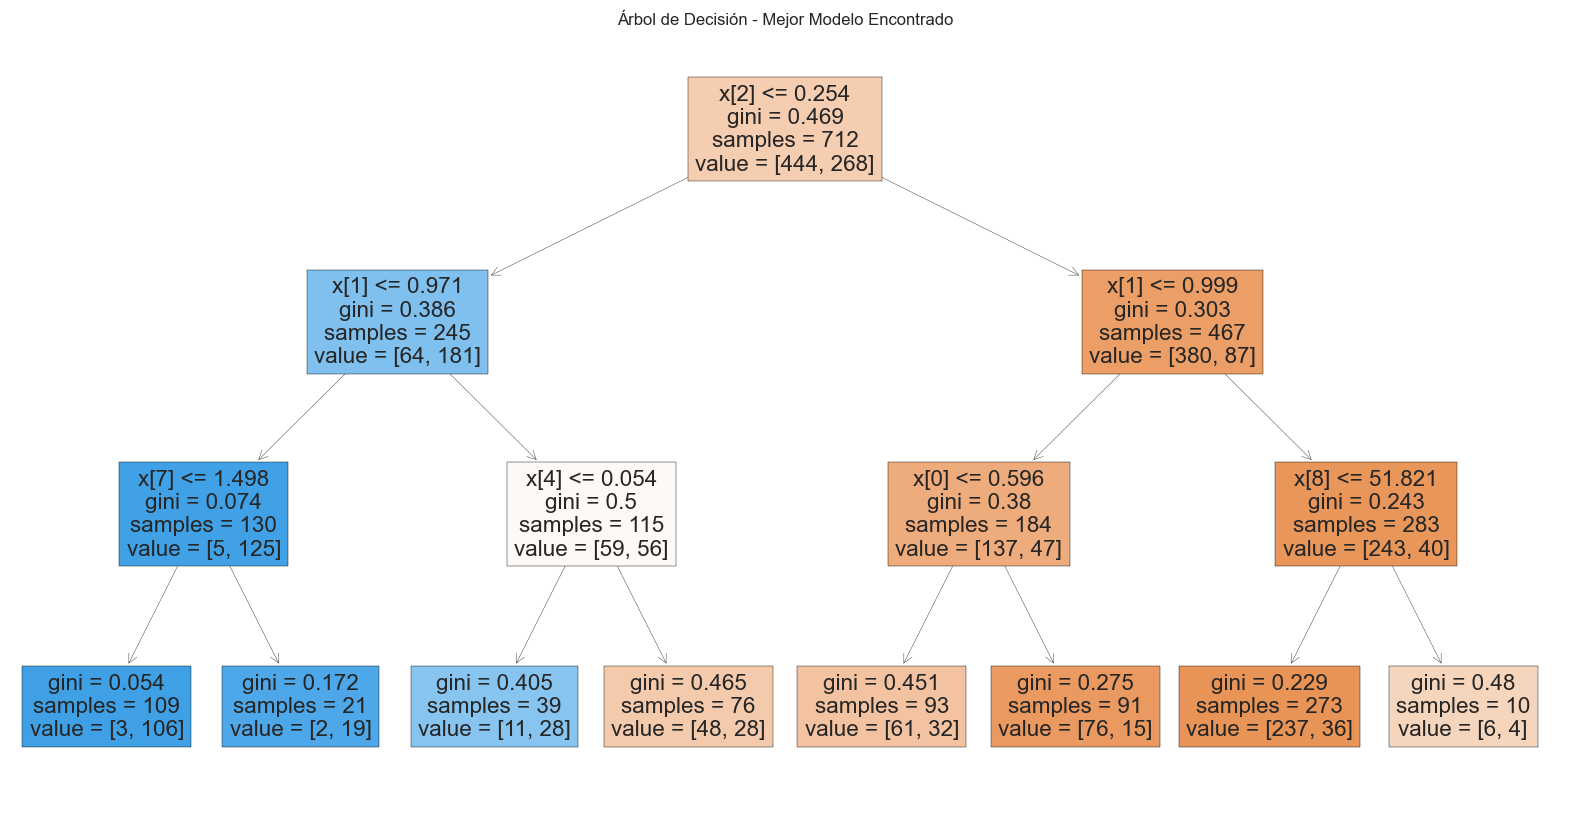

In [31]:

# Paso 3: Definir el modelo
dt = DecisionTreeClassifier()

# Paso 4: Definir los hiperparámetros a probar
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 3, 4, 5,10],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

# Paso 5: Realizar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_final, y_train)

# Paso 6: Obtener los mejores parámetros y evaluar el modelo
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_final)

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

print("Exactitud:")
print(accuracy_score(y_test, y_pred))
# Paso 7: Graficar el mejor árbol de decisión
plt.figure(figsize=(20,10))
plot_tree(best_model,filled=True)
plt.title("Árbol de Decisión - Mejor Modelo Encontrado")
plt.show()

### 3. Reducción de dimensionalidad

In [32]:
# Entrenamiento modelo PCA con escalado de los datos

# ==============================================================================
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(pd.concat([X_train_final,y_train], axis=1))

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.21317943 0.39437563 0.56006193 0.6741958  0.77219998 0.84719812
 0.90148523 0.94194804 0.98158791 1.        ]


Text(0, 0.5, 'Por. varianza acumulada')

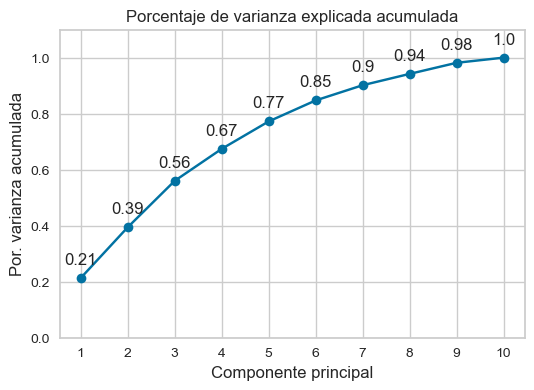

In [33]:

datos=pd.concat([X_train_final,y_train], axis=1)
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(datos.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(datos.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada')

Al analizar la ganancia de información, se observa que para alcanzar al menos un 80% de esta, se requieren al menos 6 componentes principales de los 10 calculados.  Lo anterior quiere decir que: 

-Existe baja redundancia entre las características del conjunto de datos

-Los atributos no están altamente correlacionadas entre sí.

-Cada atributo o componente principal aporta información relevante.

-La estructura subyacente de los datos requiere muchas dimensiones. 

-El conjunto de datos no se simplifica fácilmente proyectando sobre un espacio de dimensiones inferiores.

La conclusión anterior está en línea con la matriz de correlación spearman del EDA de los pasos anteriores.

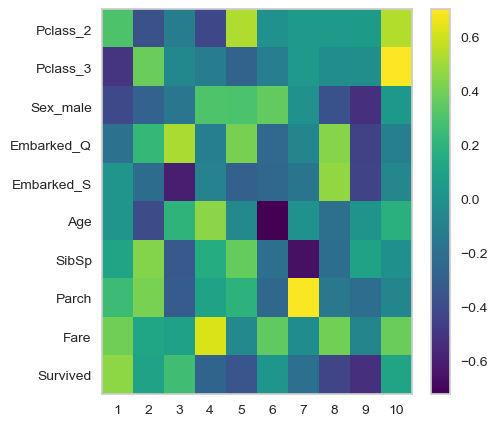

In [34]:
# Heatmap componentes
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
componentes = modelo_pca.components_
plt.imshow(componentes.T, cmap='viridis', aspect='auto')
plt.yticks(range(len(datos.columns)), datos.columns)
plt.xticks(range(len(datos.columns)), np.arange(modelo_pca.n_components_) + 1)
plt.grid(False)
plt.colorbar();

Se construye "Heatmap" para identificar las características asociadas a cada PCA

In [35]:
proyecciones = pca_pipe.transform(X=datos)
proyecciones = pd.DataFrame(
    proyecciones,
    columns = ['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6','PC7','PC8','PC9', 'PC10'],
    index   = datos.index
)
proyecciones=proyecciones.iloc[:,:6]
proyecciones.head()

,PC1,PC2,PC3,PC4,PC5,PC6
331,-0.353957,-1.577010,-0.183530,1.117238,-0.104438,-0.364065
733,0.239730,-1.857099,-0.839339,-0.842927,1.309749,0.748007
382,-1.551259,-0.470267,-0.544159,0.165329,-0.571151,0.000793
704,-1.470199,0.079922,-0.911940,0.096594,-0.237113,0.156976
813,0.456643,3.479627,-2.441489,-0.299313,0.626541,-0.467125


### 4. Caracterización de los pasajeros

#### Loadings PCA

In [36]:
pd_componentes = pd.DataFrame(componentes)
pd_componentes.head(10)

,0,1,2,3,4,5,6,7,8,9
0,0.306407,-0.505717,-0.410563,-0.187175,0.023238,0.023050,0.108058,0.254838,0.392562,0.463652
1,-0.367356,0.378525,-0.273481,0.227484,-0.218346,-0.390217,0.441533,0.418932,0.123332,0.098063
2,-0.115721,-0.057909,-0.163987,0.521728,-0.601540,0.205250,-0.324137,-0.309893,0.093800,0.265119
3,-0.412763,-0.122610,0.311004,-0.108512,-0.089451,0.455623,0.160083,0.099125,0.620481,-0.264675
4,0.536055,-0.268136,0.300164,0.410130,-0.284150,-0.051709,0.365376,0.201743,-0.053569,-0.349226
5,0.001585,-0.110876,0.360192,-0.235721,-0.242894,-0.722642,-0.196308,-0.238609,0.353503,0.027503
6,0.042239,0.047892,0.000537,-0.069176,-0.168005,0.001045,-0.660837,0.696440,-0.026381,-0.201197
7,0.049998,-0.022125,-0.365230,0.442325,0.473741,-0.196799,-0.209543,-0.148758,0.399307,-0.423465
8,0.054618,-0.019766,-0.527628,-0.439873,-0.430740,0.015624,0.099734,-0.210052,-0.071415,-0.528958
9,0.541088,0.703717,0.037534,-0.107455,-0.063248,0.183354,-0.009150,-0.069134,0.379226,0.112942


In [37]:
pd_columnas_componentes = pd.concat([X_train_final,y_train])
pd_columnas_componentes.head(0)

,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Age,SibSp,Parch,Fare,0


Complementario al heatmap, identificamos los valores numéricos de los loadings de los PCA y sus respectivas columnas

#### Iteración K-Means con los datos en su nueva representación

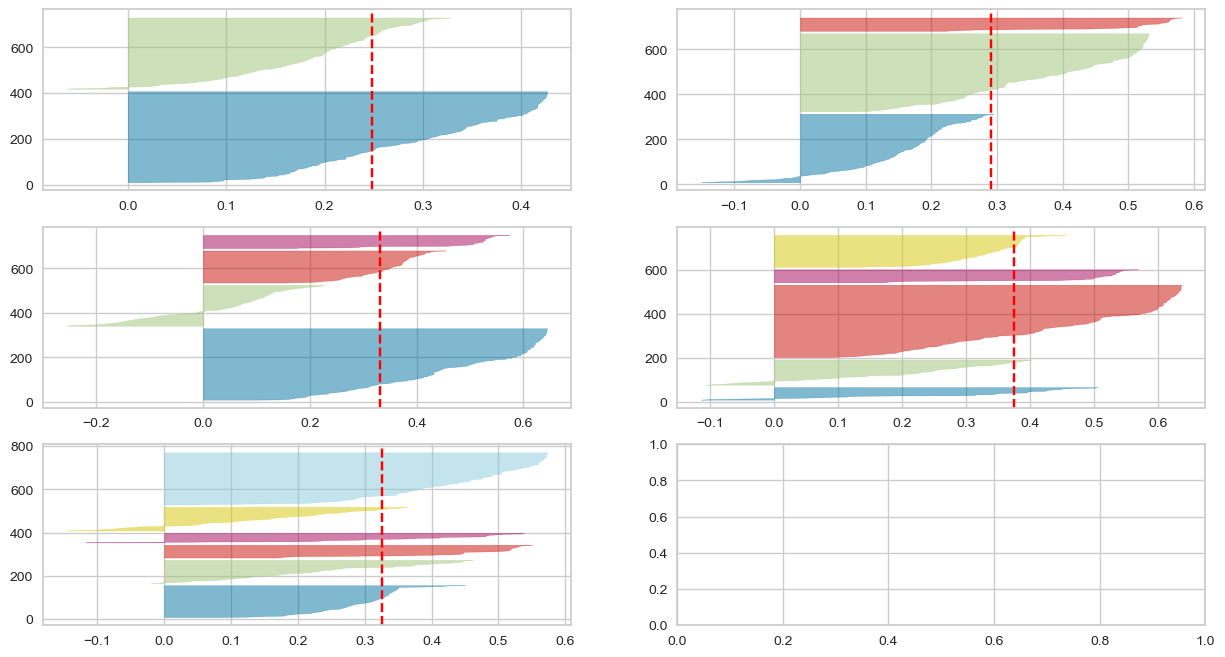

In [38]:
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5,6]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(proyecciones) #Vemos que el valor óptimo es K=2

Realizamos una iteración con los hiperperámetros de clúster K-Means, encontrando a través del indicador silueta, que 5 clúster es la cantidad óptima que maximiza el resultado del promedio (ver línea roja punteada).  Adicionalmente, todos los clúster se encuentran por encima de la línea del promedio.

Por facilidad de análisis tomaremos el K = 3.  Este nivel de clústeres, presenta una promedio de silueta aceptable y todos los clústeres se encuentar por encima del mismo. 

#### Construcción y etiquetado de Clústeres

In [39]:
km = KMeans(n_clusters=3 ,init='k-means++', max_iter=300, n_init=10, random_state=42)
#
# Fit the KMeans model
#
km.fit_predict(proyecciones)
#
# Calculate Silhoutte Score
#
score = silhouette_score(proyecciones, km.labels_, metric='euclidean')
#
# Print the score
#
print('Silhouetter Score: %.3f' % score)
cluster_labels = km.fit_predict(proyecciones)
cluster_label_mapping = {
    0: 'Cluster 1',
    1: 'Cluster 2',
    2: 'Cluster 3',
    # Agregar más etiquetas según sea necesario para tus datos
}

# Agregar una nueva columna con las etiquetas de los clusters al DataFrame
proyecciones['Cluster'] = cluster_labels

Silhouetter Score: 0.291


In [40]:
proyecciones.head(3)

,PC1,PC2,PC3,PC4,PC5,PC6,Cluster
331,-0.353957,-1.577010,-0.183530,1.117238,-0.104438,-0.364065,0
733,0.239730,-1.857099,-0.839339,-0.842927,1.309749,0.748007,0
382,-1.551259,-0.470267,-0.544159,0.165329,-0.571151,0.000793,1


Text(0.5, 1.0, 'PC1 vs. PC2')

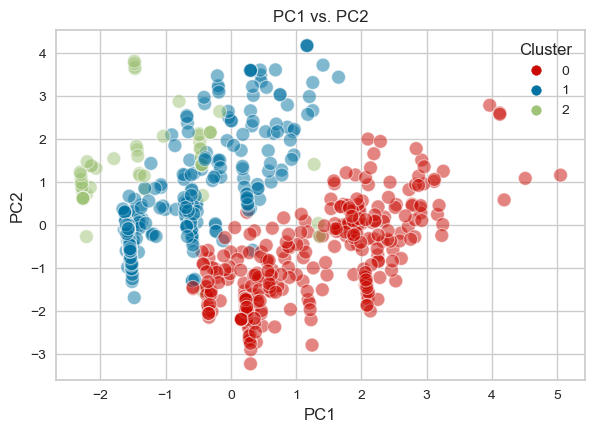

In [41]:
dataPca = proyecciones
fig = plt.figure(figsize=(15,10))
colorPalette = ["r", "b", "g"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="PC1", y="PC2", hue="Cluster", data=dataPca, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("PC1 vs. PC2")

Text(0.5, 1.0, 'PC1 vs. PC3')

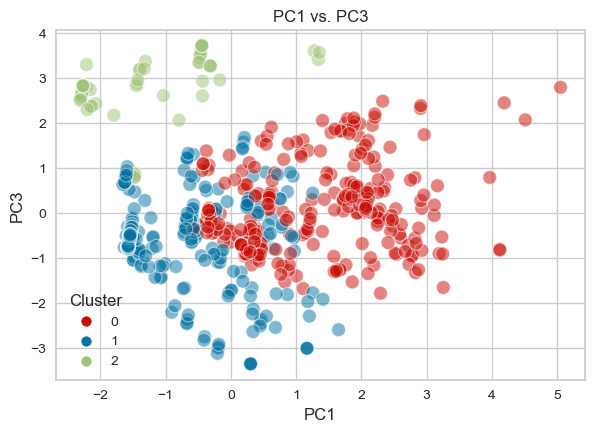

In [42]:
dataPca = proyecciones
fig = plt.figure(figsize=(15,10))
colorPalette = ["r", "b", "g"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="PC1", y="PC3", hue="Cluster", data=dataPca, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("PC1 vs. PC3")

Text(0.5, 1.0, 'PC1 vs. PC4')

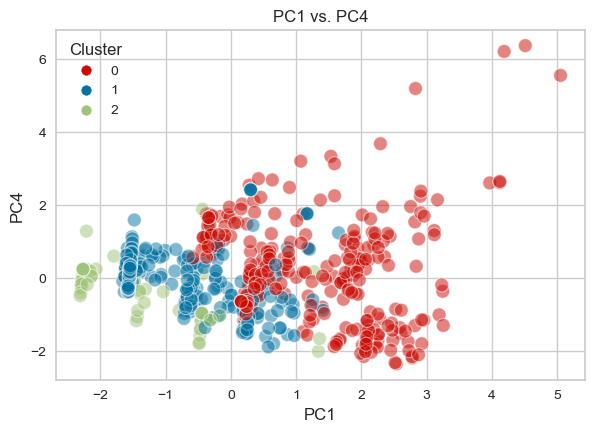

In [43]:
dataPca = proyecciones
fig = plt.figure(figsize=(15,10))
colorPalette = ["r", "b", "g"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="PC1", y="PC4", hue="Cluster", data=dataPca, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("PC1 vs. PC4")

Text(0.5, 1.0, 'PC1 vs. PC5')

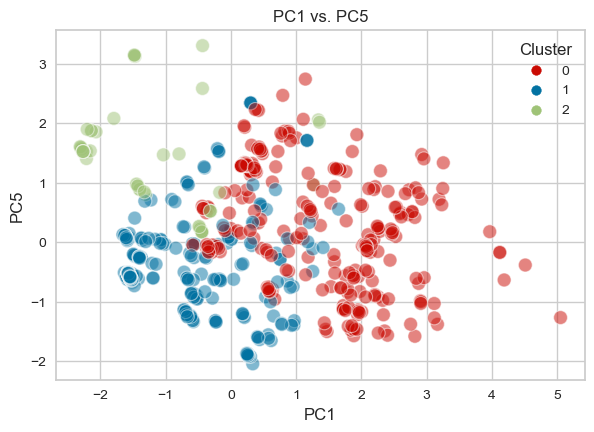

In [44]:
dataPca = proyecciones
fig = plt.figure(figsize=(15,10))
colorPalette = ["r", "b", "g"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="PC1", y="PC5", hue="Cluster", data=dataPca, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("PC1 vs. PC5")

Text(0.5, 1.0, 'PC1 vs. PC6')

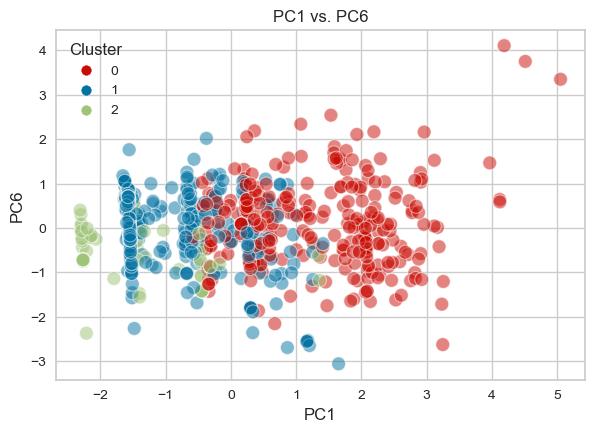

In [45]:
dataPca = proyecciones
fig = plt.figure(figsize=(15,10))
colorPalette = ["r", "b", "g"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="PC1", y="PC6", hue="Cluster", data=dataPca, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("PC1 vs. PC6")

Text(0.5, 1.0, 'PC2 vs. PC3')

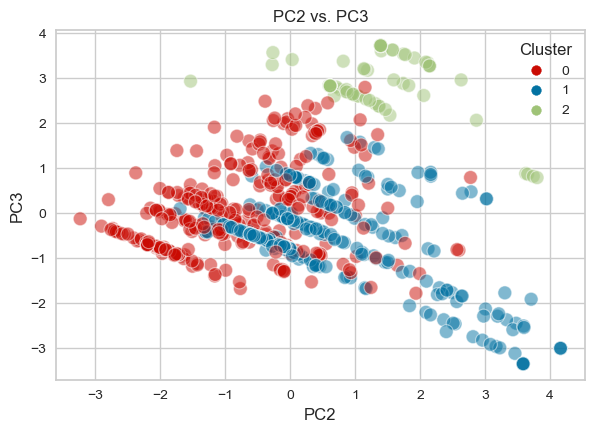

In [46]:
dataPca = proyecciones
fig = plt.figure(figsize=(15,10))
colorPalette = ["r", "b", "g"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="PC2", y="PC3", hue="Cluster", data=dataPca, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("PC2 vs. PC3")

Text(0.5, 1.0, 'PC2 vs. PC4')

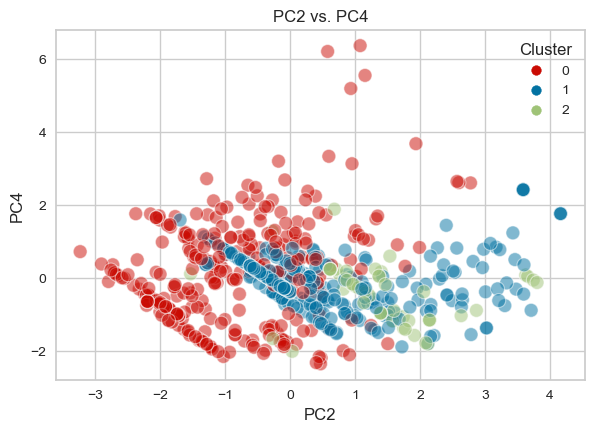

In [47]:
dataPca = proyecciones
fig = plt.figure(figsize=(15,10))
colorPalette = ["r", "b", "g"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="PC2", y="PC4", hue="Cluster", data=dataPca, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("PC2 vs. PC4")

Text(0.5, 1.0, 'PC2 vs. PC5')

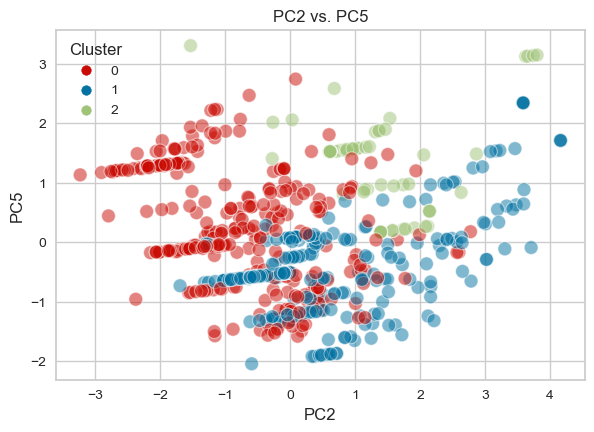

In [48]:
dataPca = proyecciones
fig = plt.figure(figsize=(15,10))
colorPalette = ["r", "b", "g"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="PC2", y="PC5", hue="Cluster", data=dataPca, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("PC2 vs. PC5")

Text(0.5, 1.0, 'PC2 vs. PC6')

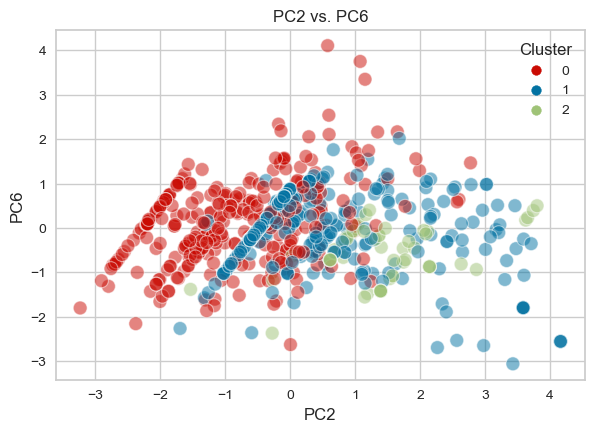

In [49]:
dataPca = proyecciones
fig = plt.figure(figsize=(15,10))
colorPalette = ["r", "b", "g"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="PC2", y="PC6", hue="Cluster", data=dataPca, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("PC2 vs. PC6")

Text(0.5, 1.0, 'PC3 vs. PC4')

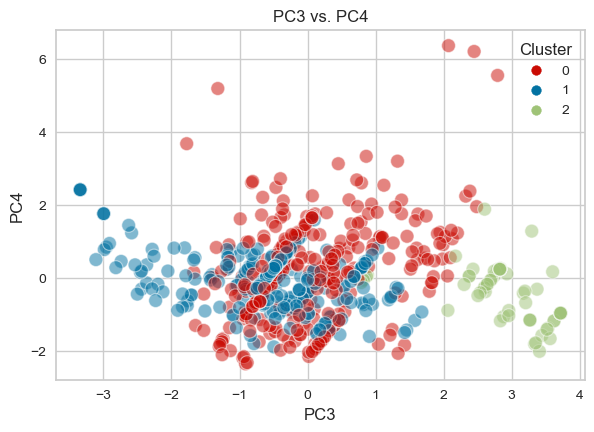

In [50]:
dataPca = proyecciones
fig = plt.figure(figsize=(15,10))
colorPalette = ["r", "b", "g"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="PC3", y="PC4", hue="Cluster", data=dataPca, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("PC3 vs. PC4")

Text(0.5, 1.0, 'PC3 vs. PC5')

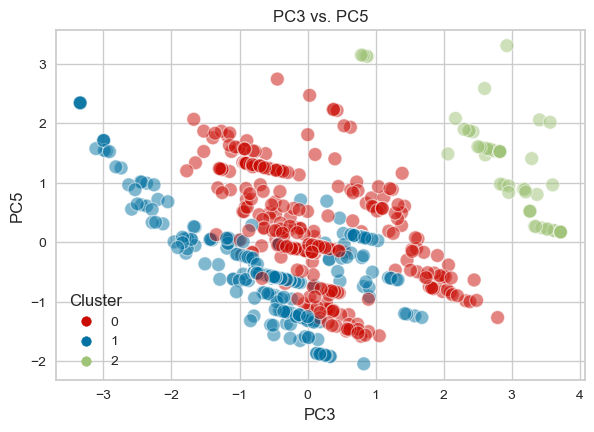

In [51]:
dataPca = proyecciones
fig = plt.figure(figsize=(15,10))
colorPalette = ["r", "b", "g"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="PC3", y="PC5", hue="Cluster", data=dataPca, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("PC3 vs. PC5")

Text(0.5, 1.0, 'PC3 vs. PC6')

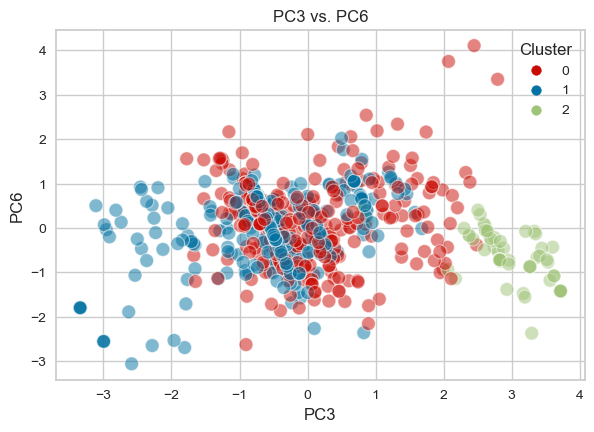

In [52]:
dataPca = proyecciones
fig = plt.figure(figsize=(15,10))
colorPalette = ["r", "b", "g"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="PC3", y="PC6", hue="Cluster", data=dataPca, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("PC3 vs. PC6")

Text(0.5, 1.0, 'PC4 vs. PC5')

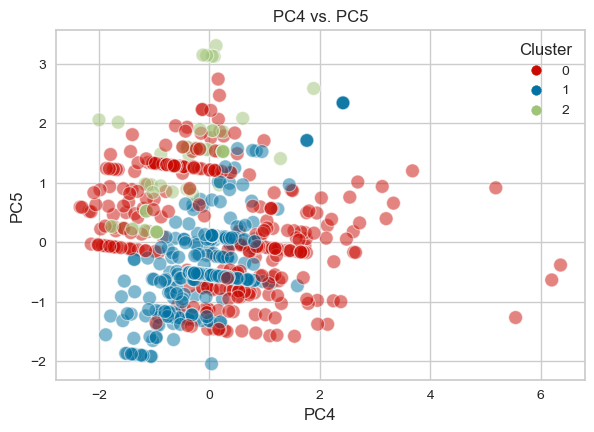

In [53]:
dataPca = proyecciones
fig = plt.figure(figsize=(15,10))
colorPalette = ["r", "b", "g"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="PC4", y="PC5", hue="Cluster", data=dataPca, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("PC4 vs. PC5")

Text(0.5, 1.0, 'PC4 vs. PC6')

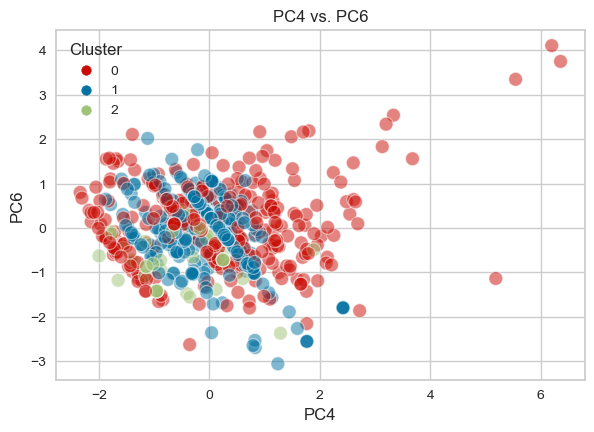

In [54]:
dataPca = proyecciones
fig = plt.figure(figsize=(15,10))
colorPalette = ["r", "b", "g"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="PC4", y="PC6", hue="Cluster", data=dataPca, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("PC4 vs. PC6")

Text(0.5, 1.0, 'PC5 vs. PC6')

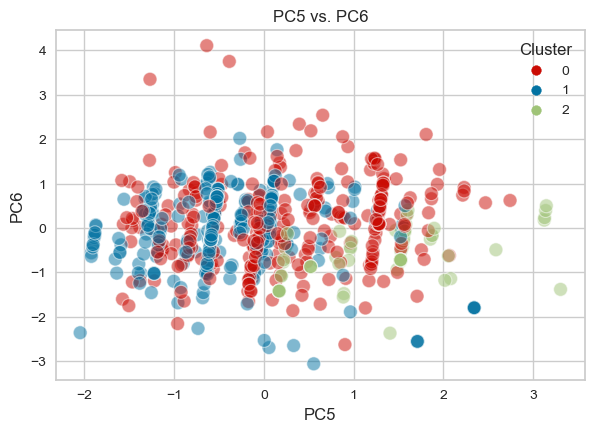

In [55]:
dataPca = proyecciones
fig = plt.figure(figsize=(15,10))
colorPalette = ["r", "b", "g"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="PC5", y="PC6", hue="Cluster", data=dataPca, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("PC5 vs. PC6")

Vemos que con K=3, en el plot de PC1 Vs. PC2 podemos separar bien los 3 clusters.
Recordemos que según el heat map de componentes y la matriz de loadings:

El PC1 presenta: 
    -Positivamente Survided.
    -Positivamente Fare.
    -Positivamente PClass_2
    -Negativamente Pclass_3
    -Negativamente Sex_male (o sea mujeres, debido al one hot encoding).

El PC2 representa: 
    -Positivamente Sibsp y Parch
    -Positivamente PClass_3.
    -Negativamente Pclass_2.
    -Negativamente Age.
    